In [ ]:
import pandas as pd
import re


In [17]:
df = pd.read_csv("../data/synthetic_right.csv")

In [18]:
df.describe()

,Unnamed: 0,elapsed,refined_dice3d_0.1,refined_TP_0.1,refined_FP_0.1,refined_FN_0.1,refined_TN_0.1,refined_chamfer_0.1,backproj_dice3d_0.1,backproj_TP_0.1,...,refined_dice3d_1.0,refined_TP_1.0,refined_FP_1.0,refined_FN_1.0,refined_TN_1.0,backproj_dice3d_1.0,backproj_TP_1.0,backproj_FP_1.0,backproj_FN_1.0,backproj_TN_1.0
count,4.0,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.0,4.0,4.0,4.000000,4.000000,4.0,4.0,4.0,4.000000,4.000000
mean,0.0,3.840143,0.004928,532.750000,215020.75000,21.750000,424.750000,515.242299,0.075508,108.750000,...,0.0,0.0,0.0,554.500000,215445.500000,0.0,0.0,0.0,554.500000,215445.500000
std,0.0,0.213579,0.001551,168.677948,594.38785,26.737926,632.080361,65.965064,0.041589,74.298385,...,0.0,0.0,0.0,162.239535,162.239535,0.0,0.0,0.0,162.239535,162.239535
min,0.0,3.627040,0.003358,361.000000,214242.00000,0.000000,3.000000,426.407019,0.019221,19.000000,...,0.0,0.0,0.0,418.000000,215235.000000,0.0,0.0,0.0,418.000000,215235.000000
25%,0.0,3.749319,0.003847,415.750000,214722.00000,1.500000,3.000000,485.297086,0.064593,64.000000,...,0.0,0.0,0.0,431.500000,215359.500000,0.0,0.0,0.0,431.500000,215359.500000
50%,0.0,3.798517,0.004771,516.500000,215140.00000,15.000000,178.000000,530.679306,0.081639,116.000000,...,0.0,0.0,0.0,517.500000,215482.500000,0.0,0.0,0.0,517.500000,215482.500000
75%,0.0,3.889341,0.005851,633.500000,215438.75000,35.250000,599.750000,560.624519,0.092553,160.750000,...,0.0,0.0,0.0,640.500000,215568.500000,0.0,0.0,0.0,640.500000,215568.500000
max,0.0,4.136499,0.006812,737.000000,215561.00000,57.000000,1340.000000,573.203563,0.119531,184.000000,...,0.0,0.0,0.0,765.000000,215582.000000,0.0,0.0,0.0,765.000000,215582.000000


In [15]:
def roc(df):
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    
    pattern = re.compile(r"refined_TP_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
            
    fpr_list, tpr_list = [], []
    for t in thresholds:
        TP = df[f"refined_TP_{t}"].sum()
        TN = df[f"refined_TN_{t}"].sum()
        FP = df[f"refined_FP_{t}"].sum()
        FN = df[f"refined_FN_{t}"].sum()

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        tpr_list.append(TPR)
        fpr_list.append(FPR)
    
    fpr_list, tpr_list = zip(*sorted(zip(fpr_list, tpr_list)))
    roc_auc = auc(fpr_list, tpr_list)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr_list, tpr_list, marker='o', label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

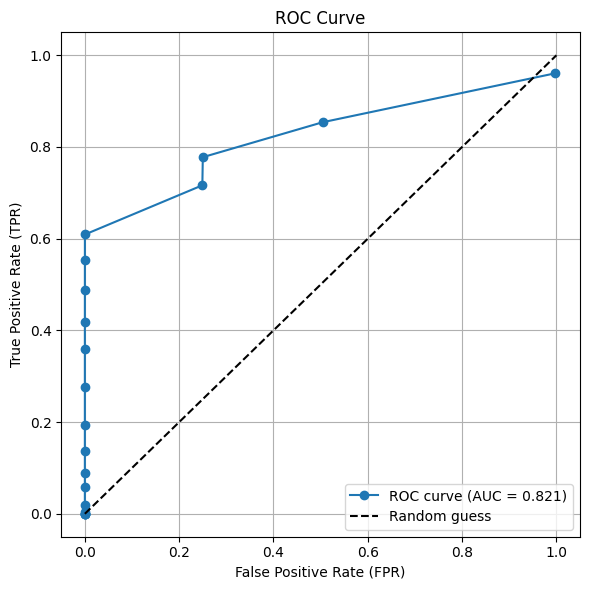

In [16]:
roc(df)